In [155]:
from sklearn.model_selection import train_test_split

import datetime
import pandas as pd
import numpy as np

import panel as pn
pn.extension('tabulator', sizing_mode="stretch_width")

import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn.model_selection import *
from sklearn.metrics import *

pd.options.display.float_format = "{:.1f}".format
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight") 

import warnings
warnings.filterwarnings("ignore")

In [156]:
# for non-scientific output of floats
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [157]:
pd.set_option('display.max_columns', None)

In [158]:
def environment():
    try:
        get_ipython()
        return "notebook"
    except:
        return "server"
environment()


'notebook'

In [159]:
PALETTE = ["#ff6f69", "#ffcc5c", "#88d8b0", ]
pn.Row(
    pn.layout.HSpacer(height=50, background=PALETTE[0]),
    pn.layout.HSpacer(height=50, background=PALETTE[1]),
    pn.layout.HSpacer(height=50, background=PALETTE[2]),
)


Row(sizing_mode='stretch_width')
    [0] HSpacer(background='#ff6f69', height=50)
    [1] HSpacer(background='#ffcc5c', height=50)
    [2] HSpacer(background='#88d8b0', height=50)

In [160]:
form_m1 = pd.read_excel('../data/form_m1.xlsx', sheet_name=None)

In [161]:
df_p1   = form_m1['Р1']
df_pp1  = form_m1['Раздел 1']

In [162]:
# data preprocessing

In [163]:
df_p1.head()

,Регион,Округ,Год,Направления реализации государственной молодeжной политики,№ строки,"Бюджет СРФ, руб","Бюджет МО, руб",Кол-во грантов,"Бюджет грантов, руб","Численность молодeжи, задействованной в программных мероприятиях по направлению","Количество детских и молодeжных общественных объединений, работающих по данному",Unnamed: 11,Unnamed: 12
0,Алтайский край,СФО,2021,Вовлечение молодeжи в инновационную деятельнос...,1,7176890.000,123085.000,4.000,35485.000,3845.000,44.000,NaN,NaN
1,Алтайский край,СФО,2021,биомедицина,2,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN
2,Алтайский край,СФО,2021,промышленные технологии\n (нанотехн...,3,0.000,0.000,0.000,0.000,10.000,0.000,NaN,NaN
3,Алтайский край,СФО,2021,аэрокосмос,4,0.000,0.000,0.000,0.000,28.000,1.000,NaN,NaN
4,Алтайский край,СФО,2021,сельское хозяйство,5,0.000,1000.000,0.000,0.000,247.000,0.000,NaN,NaN


In [164]:
df_p1.shape

(2295, 13)

In [165]:
df_p1 = df_p1.drop(columns=['Unnamed: 11', 'Unnamed: 12'])

In [166]:
df_p1.dtypes

Регион                                                                               object
Округ                                                                                object
Год                                                                                   int64
Направления реализации государственной молодeжной политики                           object
№ строки                                                                              int64
Бюджет СРФ, руб                                                                     float64
Бюджет МО, руб                                                                      float64
Кол-во грантов                                                                      float64
Бюджет грантов, руб                                                                 float64
Численность молодeжи, задействованной в программных мероприятиях по направлению     float64
Количество детских и молодeжных общественных объединений, работающих по данному 

In [167]:
df_p1.isna().sum()

Регион                                                                                0
Округ                                                                                 0
Год                                                                                   0
Направления реализации государственной молодeжной политики                            0
№ строки                                                                              0
Бюджет СРФ, руб                                                                     385
Бюджет МО, руб                                                                      306
Кол-во грантов                                                                      442
Бюджет грантов, руб                                                                 449
Численность молодeжи, задействованной в программных мероприятиях по направлению     147
Количество детских и молодeжных общественных объединений, работающих по данному     422
dtype: int64

In [168]:
df_p1 = df_p1.fillna(0)

In [169]:
# make interactive dataframe
idf = df_p1.interactive()

### Расходы по разным направлениям с выбором округа (одиночный или множественный)

In [170]:
df_p1['Год'].dtype

dtype('int64')

In [171]:
# define panel widgets
year_slider = pn.widgets.IntSlider(name='Year slider', start=int(df_p1['Год'].min() - 1), end=int(df_p1['Год'].max()), step=1, value=int(df_p1['Год'].min()) - 1)

In [172]:
districts = list(df_p1['Округ'].unique())

In [173]:
districts

['СФО', 'ДФО', 'СЗФО', 'ЮФО', 'ЦФО', 'СКФО', 'ПФО', 'УФО']

In [174]:
# multiple choice buttons
districts_buttons = pn.widgets.ToggleGroup(
                        name='dstr_btn',
                        options=districts,
                        value=[districts],
                        button_type='success'
                    )

In [175]:
idf.columns

In [176]:
idf.columns[3]

In [177]:
ipipeline_1 = idf[(idf['Округ'].isin(districts_buttons)) & (idf['Год'] == year_slider)] \
                .groupby('Направления реализации государственной молодeжной политики', as_index=True) \
                .agg({   'Бюджет СРФ, руб': 'sum',
                         'Бюджет МО, руб': 'sum',
                         'Кол-во грантов': 'sum',
                         'Бюджет грантов, руб': 'sum',
                         'Численность молодeжи, задействованной в программных мероприятиях по направлению': 'sum',
                         'Количество детских и молодeжных общественных объединений, работающих по данному ': 'sum'}) \
                .rename(columns={'Направления реализации государственной молодeжной политики' : 'Направления реализации'})

In [178]:
# interactive table
itable_1 = ipipeline_1.pipe(pn.widgets.Tabulator, pagination='remote', page_size=10)

In [179]:
itable_1

In [180]:
# add select button
select = pn.widgets.Select(name='Выберите округ', options=districts)

In [181]:
ipipeline_2 = idf[idf['Округ'] == (select)] \
                .groupby('Направления реализации государственной молодeжной политики', as_index=True) \
                .agg({   'Бюджет СРФ, руб': 'sum',
                         'Бюджет МО, руб': 'sum',
                         'Кол-во грантов': 'sum',
                         'Бюджет грантов, руб': 'sum',
                         'Численность молодeжи, задействованной в программных мероприятиях по направлению': 'sum',
                         'Количество детских и молодeжных общественных объединений, работающих по данному ': 'sum'}) \
                .rename(columns={'Направления реализации государственной молодeжной политики' : 'Направления реализации'})

In [182]:
itable_2 = ipipeline_2.pipe(pn.widgets.Tabulator, pagination='remote', page_size=10)

In [183]:
itable_2

### График расходов по округам с выбором типа бюджета

In [184]:
budget_types=sorted(list(df_p1.columns[5:9]))[:3]

In [185]:
budget_types

['Бюджет МО, руб', 'Бюджет СРФ, руб', 'Бюджет грантов, руб']

In [186]:
# create budget selection 
select_budget = pn.widgets.Select(name='Выберите тип бюджета', options=budget_types)

In [187]:
idf = df_p1.interactive()

In [188]:
idf.head()

In [189]:
ipipline_3 = idf.groupby('Округ', as_index=True).agg({select_budget : 'sum'})

In [190]:
ihvplot = ipipline_3.hvplot(x='Округ', y=select_budget, color=PALETTE, line_width=6, height=600)

In [191]:
ihvplot

### Интерактивный раздел 1

In [192]:
df_pp1 = form_m1['Раздел 1']

In [193]:
list(df_pp1.iloc[3])

['Названия строк',
 'Сумма по полю Бюджет СРФ, руб',
 'Сумма по полю Бюджет МО, руб',
 'Сумма по полю Кол-во грантов',
 'Сумма по полю Бюджет грантов, руб',
 'Сумма по полю Численность молодeжи, задействованной в программных мероприятиях по направлению',
 'Сумма по полю Количество детских и молодeжных общественных объединений, работающих по данному ']

In [194]:
df_pp1.columns = list(df_pp1.iloc[3])

In [195]:
df_pp1 = df_pp1[4:].rename(columns={'Названия строк' : 'Направления'})

In [196]:
df_pp1.head()

,Направления,"Сумма по полю Бюджет СРФ, руб","Сумма по полю Бюджет МО, руб",Сумма по полю Кол-во грантов,"Сумма по полю Бюджет грантов, руб","Сумма по полю Численность молодeжи, задействованной в программных мероприятиях по направлению","Сумма по полю Количество детских и молодeжных общественных объединений, работающих по данному"
4,Вовлечение молодeжи в инновационную деятельнос...,982469474,170598050,1117,553443996,1737632,9337
5,биомедицина,35173484,3195230,55,13311837,22418,105
6,промышленные технологии\n (нанотехн...,59792583,2824921,116,29842264,125784,214
7,аэрокосмос,19111750,975286,40,2601965,34937,79
8,сельское хозяйство,170691937,15548670,140,361437104,63359,506


In [197]:
df_pp1 = df_pp1.set_index('Направления').head()

In [198]:
idf = df_pp1.interactive()

In [199]:
ipipeline_3 = idf

In [200]:
# make interactive table
pp1_pipeline = ipipeline_3.pipe(pn.widgets.Tabulator, pagination='remote', page_size = 10, sizing_mode='stretch_width') 

In [201]:
pp1_pipeline

### Р6

In [202]:
df_p6 = form_m1['Р6']

In [203]:
df_p6.isna().sum()

Регион                                                                               0
Округ                                                                                0
Год                                                                                  0
Наименование                                                                         0
№ строки                                                                             0
Количество форумов соответствующего уровня, прошедших на территории субъекта Рос    43
Численность участников форумов соответствующего уровня, чел                         27
Объeм рег. финансирования (в том числе посредством финансирования транспортных и    48
Объeм мун. финансирования (в том числе посредством финансирования транспортных и    58
dtype: int64

In [204]:
df_p6 = df_p6.fillna(0)

In [205]:
df_p6.head(3)

,Регион,Округ,Год,Наименование,№ строки,"Количество форумов соответствующего уровня, прошедших на территории субъекта Рос","Численность участников форумов соответствующего уровня, чел",Объeм рег. финансирования (в том числе посредством финансирования транспортных и,Объeм мун. финансирования (в том числе посредством финансирования транспортных и
0,Республика Адыгея,ЮФО,2021,Всероссийские молодeжные форумы,55,0.000,0.000,54000.000,0.000
1,Республика Адыгея,ЮФО,2021,Окружные молодeжные форумы,56,2.000,300.000,0.000,0.000
2,Республика Адыгея,ЮФО,2021,Региональные и межрегиональные молодeжные форумы,57,6.000,900.000,343460.000,0.000


In [206]:
df_p6.columns

Index(['Регион', 'Округ', 'Год', 'Наименование', '№ строки',
       'Количество форумов соответствующего уровня, прошедших на территории субъекта Рос',
       'Численность участников форумов соответствующего уровня, чел',
       'Объeм рег. финансирования (в том числе посредством финансирования транспортных и',
       'Объeм мун. финансирования (в том числе посредством финансирования транспортных и'],
      dtype='object')

  
 Будем считать, что запуск форума был удачным и его
 можно повторно запустить, если на него пришло много человек

In [207]:
df_p6.head(3)

,Регион,Округ,Год,Наименование,№ строки,"Количество форумов соответствующего уровня, прошедших на территории субъекта Рос","Численность участников форумов соответствующего уровня, чел",Объeм рег. финансирования (в том числе посредством финансирования транспортных и,Объeм мун. финансирования (в том числе посредством финансирования транспортных и
0,Республика Адыгея,ЮФО,2021,Всероссийские молодeжные форумы,55,0.000,0.000,54000.000,0.000
1,Республика Адыгея,ЮФО,2021,Окружные молодeжные форумы,56,2.000,300.000,0.000,0.000
2,Республика Адыгея,ЮФО,2021,Региональные и межрегиональные молодeжные форумы,57,6.000,900.000,343460.000,0.000


In [208]:
idf = df_p6.interactive()

In [209]:
iscatter_select = pn.widgets.Select(name='Выбор форума', options=list(df_p6['Наименование'].unique())[:4])

In [210]:
# топ-10 по численности
iscatter = idf[idf['Наименование'] == iscatter_select] \
            .groupby('Регион', as_index=True) \
            .agg({'Численность участников форумов соответствующего уровня, чел' : 'sum'}) \
            .rename(columns={'Численность участников форумов соответствующего уровня, чел' : 'Кол-во участников'}) \
            .sort_values('Кол-во участников', ascending=False) \
            .head(10)

In [211]:
#hvplot.help('scatter', generic=False, style=False)

In [212]:
iscatter_plot = iscatter.hvplot.scatter(x='Регион', y='Кол-во участников', 
                  legend='top', height=800, width=1400, title=iscatter_select)

In [213]:
iscatter_plot

# Models catboost

In [225]:
P1 = form_m1['Р1']

In [227]:
P1 = P1.drop('Unnamed: 11', axis=1)

In [228]:
P1 = P1.drop('Unnamed: 12', axis=1)

In [229]:
P1 = P1.drop('№ строки', axis=1)

In [230]:
df = P1

In [231]:
df = df.fillna(0)

In [232]:
cat_features = df.select_dtypes(include=['object']).columns.tolist()
cat_features

['Регион',
 'Округ',
 'Направления реализации государственной молодeжной политики']

### Преобразованиие данных в X и y

In [234]:
X = df.drop(['Количество детских и молодeжных общественных объединений, работающих по данному '], axis=1)
y_regression = df['Количество детских и молодeжных общественных объединений, работающих по данному ']

## Обучение и тестирование моделей

In [236]:
from sklearn.model_selection import train_test_split

In [237]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn.model_selection import *
from sklearn.metrics import *

pd.options.display.float_format = "{:.1f}".format
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight") 

import warnings
warnings.filterwarnings("ignore")

### Подход №1: Регрессия

In [239]:
X_train, X_val, y_train, y_val = train_test_split(X, y_regression, test_size=0.2, random_state=42)

In [240]:
model_regression = CatBoostRegressor(
    verbose=100,
    cat_features=cat_features
)

model_regression.fit(X_train, y_train, eval_set=(X_val, y_val))

Learning rate set to 0.056018
0:	learn: 929.6415169	test: 879.2215631	best: 879.2215631 (0)	total: 59.3ms	remaining: 59.3s
100:	learn: 714.1821584	test: 863.8938694	best: 862.7996070 (74)	total: 355ms	remaining: 3.16s
200:	learn: 568.9023986	test: 867.0724713	best: 862.5310868 (120)	total: 571ms	remaining: 2.27s
300:	learn: 415.9822076	test: 870.6408400	best: 862.5310868 (120)	total: 759ms	remaining: 1.76s
400:	learn: 348.2948774	test: 874.6994197	best: 862.5310868 (120)	total: 938ms	remaining: 1.4s
500:	learn: 306.8356715	test: 878.6161781	best: 862.5310868 (120)	total: 1.11s	remaining: 1.11s
600:	learn: 260.9969871	test: 888.8254703	best: 862.5310868 (120)	total: 1.3s	remaining: 861ms
700:	learn: 241.9164157	test: 892.3683514	best: 862.5310868 (120)	total: 1.49s	remaining: 634ms
800:	learn: 218.5141038	test: 897.0638050	best: 862.5310868 (120)	total: 1.67s	remaining: 416ms
900:	learn: 205.5294980	test: 898.4634617	best: 862.5310868 (120)	total: 1.85s	remaining: 204ms
999:	learn: 192.

In [241]:
preds_test_regression = model_regression.predict(X_val[model_regression.feature_names_])

# feature_importance

Text(0.5, 1.0, 'Feature Importance')

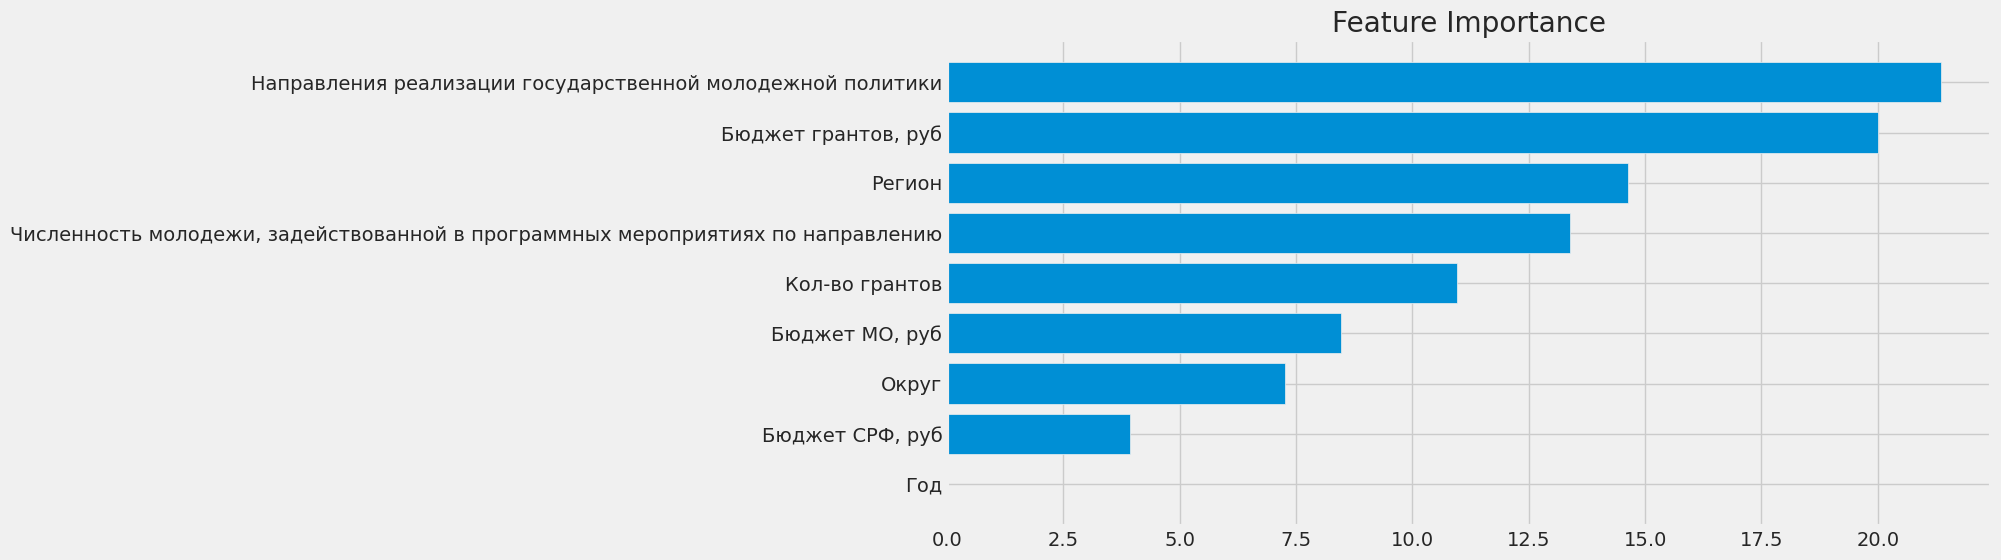

In [243]:
feature_importance = model_regression.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

# Анализ

In [246]:
corr=df.corr()
corr

,Год,"Бюджет СРФ, руб","Бюджет МО, руб",Кол-во грантов,"Бюджет грантов, руб","Численность молодeжи, задействованной в программных мероприятиях по направлению","Количество детских и молодeжных общественных объединений, работающих по данному"
Год,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Бюджет СРФ, руб",NaN,1.0,0.1,0.0,0.1,0.2,0.0
"Бюджет МО, руб",NaN,0.1,1.0,0.0,0.0,0.3,0.1
Кол-во грантов,NaN,0.0,0.0,1.0,0.1,0.0,0.0
"Бюджет грантов, руб",NaN,0.1,0.0,0.1,1.0,0.1,0.0
"Численность молодeжи, задействованной в программных мероприятиях по направлению",NaN,0.2,0.3,0.0,0.1,1.0,0.1
"Количество детских и молодeжных общественных объединений, работающих по данному",NaN,0.0,0.1,0.0,0.0,0.1,1.0


<Axes: >

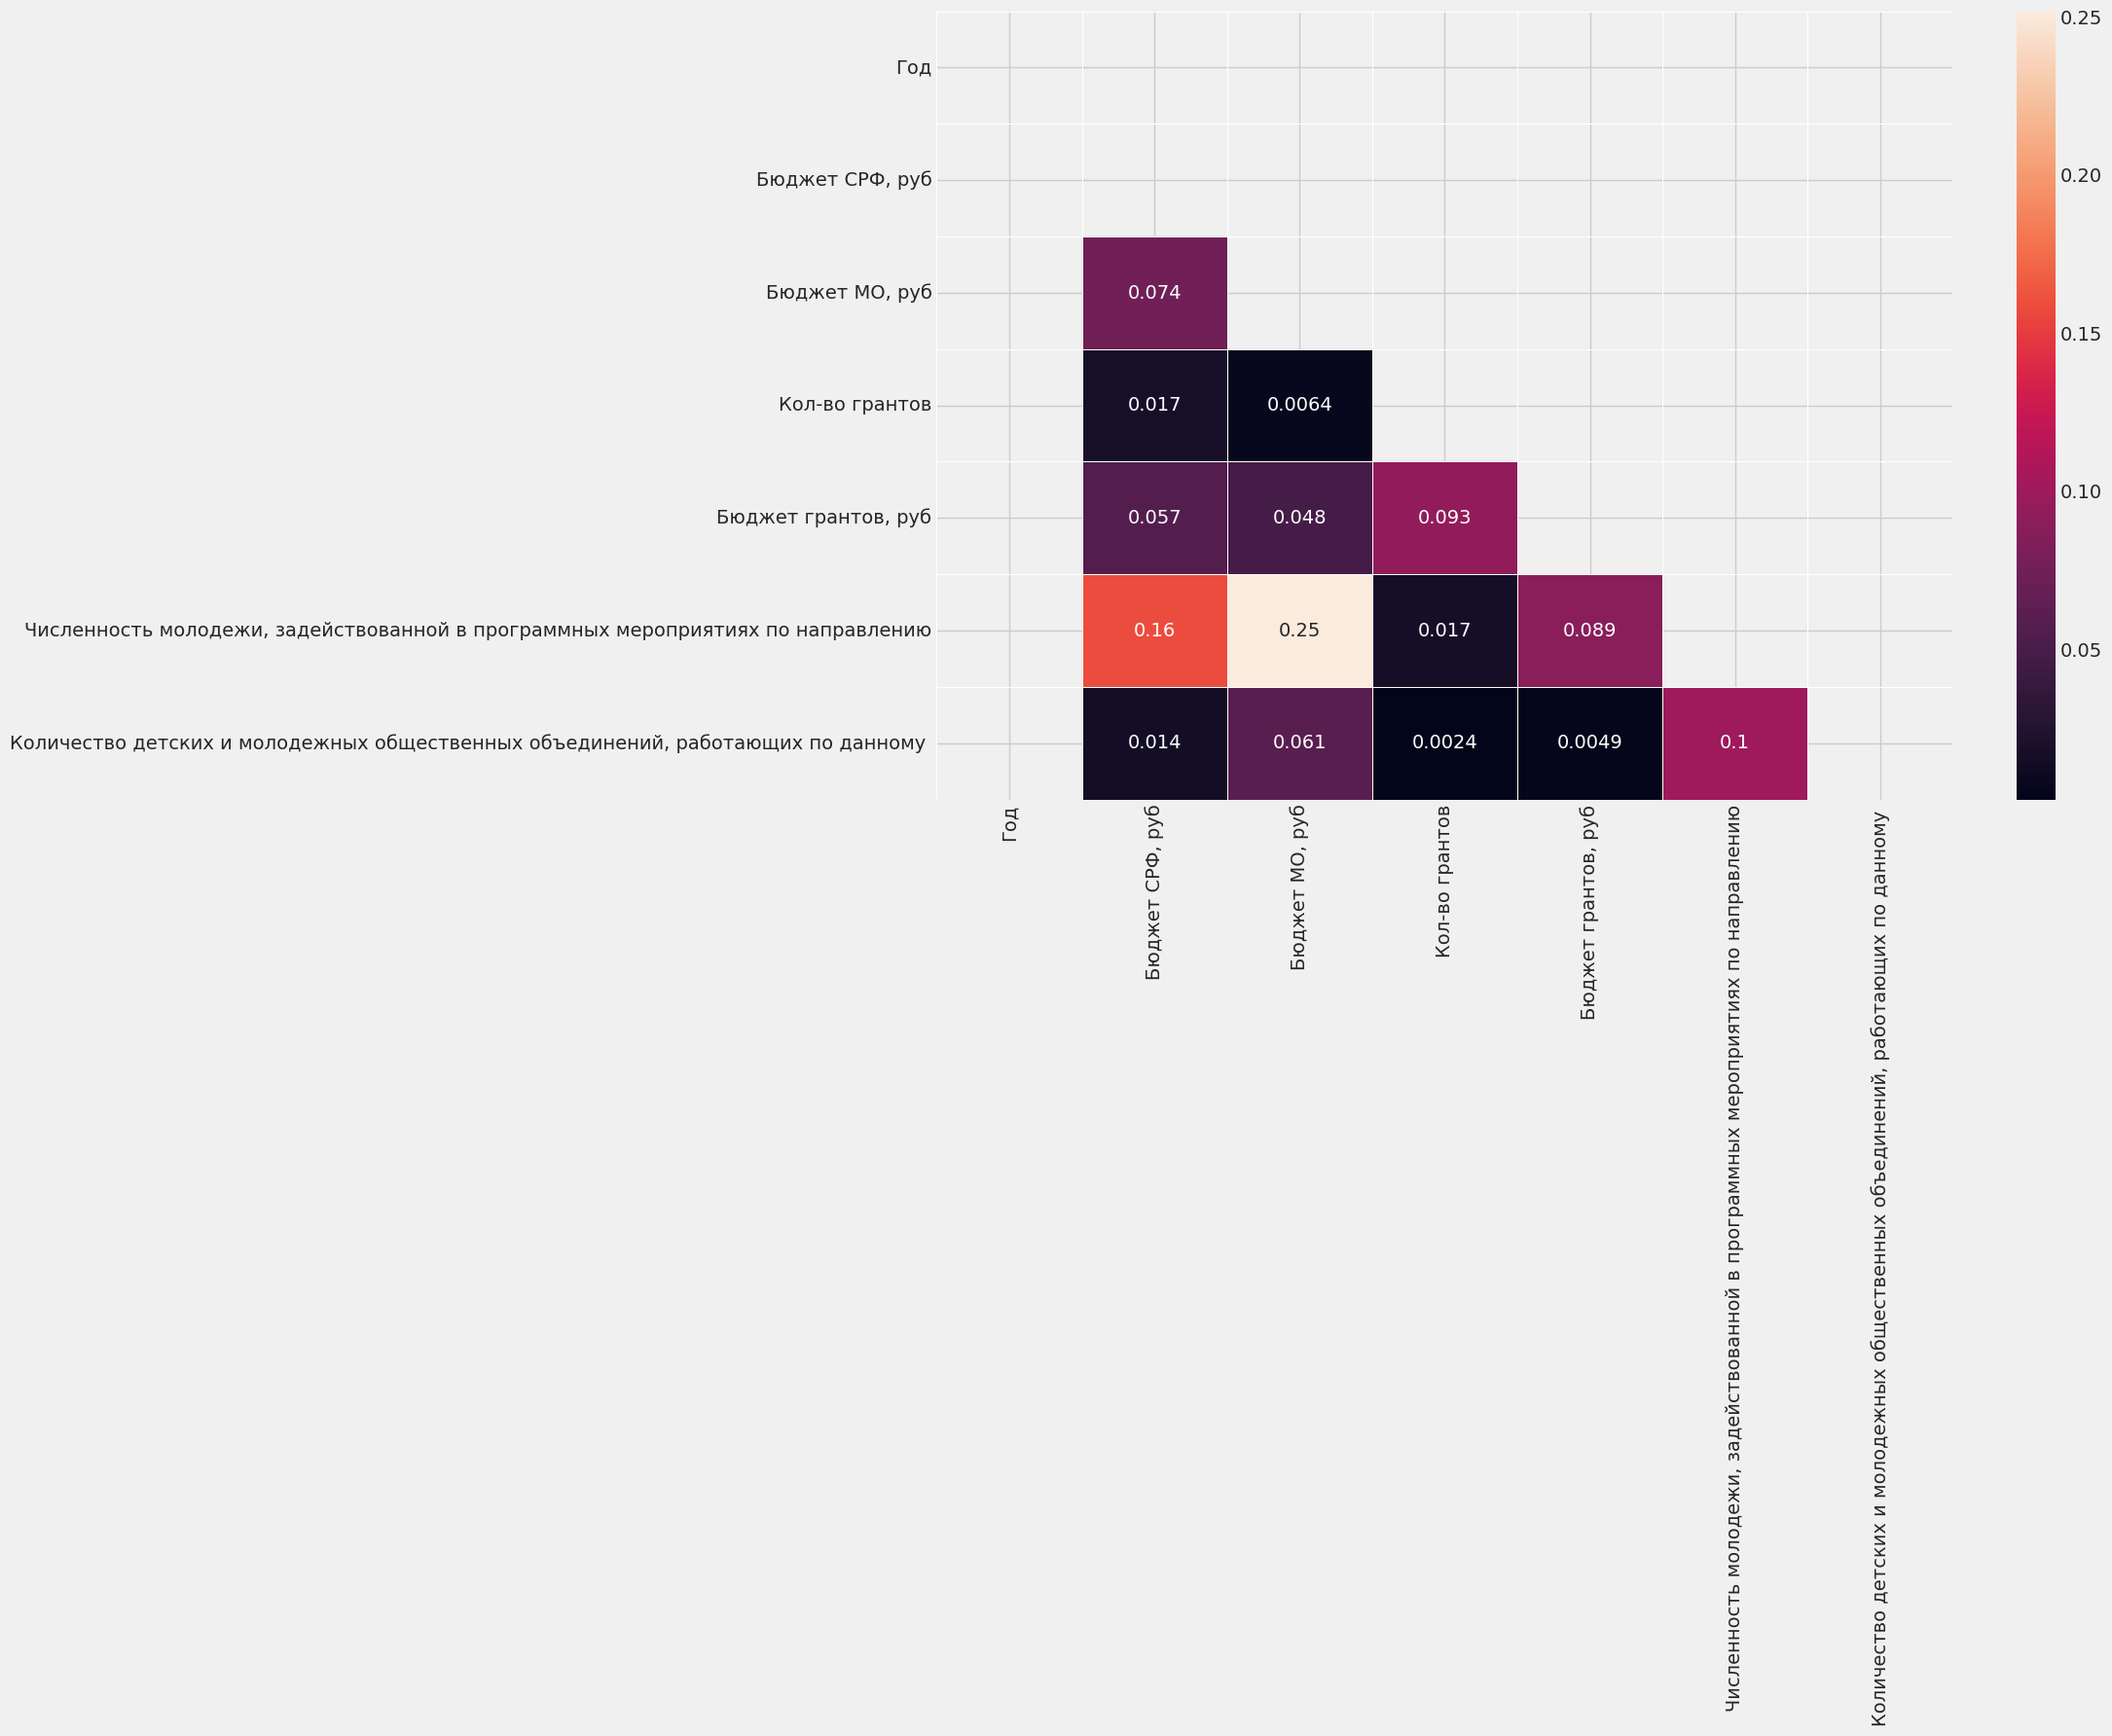

In [247]:
plt.figure(figsize=(15,10))
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, linewidths=.5,annot=True,mask=mask)

In [251]:
df.describe()

,Год,"Бюджет СРФ, руб","Бюджет МО, руб",Кол-во грантов,"Бюджет грантов, руб","Численность молодeжи, задействованной в программных мероприятиях по направлению","Количество детских и молодeжных общественных объединений, работающих по данному"
count,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
mean,2021.0,7518926.6,2266770.6,6.2,2080830.9,37561.1,126.8
std,0.0,54222180.2,14784797.4,120.8,24736296.8,114352.0,923.0
min,2021.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2021.0,0.0,0.0,0.0,0.0,280.0,0.0
50%,2021.0,105490.0,80865.0,0.0,0.0,4296.0,12.0
75%,2021.0,1857643.0,777091.0,2.0,499989.5,27394.0,78.0
max,2021.0,1418314800.0,537510446.0,5735.0,1135202650.0,2000265.0,34141.0


### Making dashboard

In [ ]:
??pn.pane.JPG

In [ ]:
# layout template
template = pn.template.FastListTemplate(
    title='молодежный-бит хакатон', 
    sidebar=[pn.pane.Markdown("# Дашборд"), 
             pn.pane.Markdown("#### Написать на русском"), 
             pn.pane.Markdown("## Настройки"),
             pn.pane.Markdown("Регулировка года (на стадии разработки)"), 
             year_slider],
    main=[pn.Row(pn.Column(iscatter_select, iscatter_plot.panel(width=8000), margin=(0,25))),
          pn.Row(pn.Column(districts_buttons, itable_1.panel(width=500))),
          pn.Row(pn.Column(select_budget, ihvplot.panel(width=500))),
          pn.Row(pn.Column(pp1_pipeline.panel(width=800), margin=(0,25)))],
    accent_base_color="#88d8b0",
    header_background="#88d8b0",
)
template.show()
#template.servable();